In [1]:
import copy
from functools import partial
from typing import *

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wandb
import wandb.apis

api = wandb.Api()

In [2]:
def load_one(run: wandb.apis.public.Run) -> Dict[str, Any]:
    if "count" in run.summary:
        task = run.config["task"]["name"]
        mc = run.summary["model_config"]
        score_key = dict(
            squad="match",
            triviaqa="match",
            cnn_dailymail="rougeL",
            wikitext_bpc="bpc",
            repetition="match_length_char",
        )[task]
        sparsity = copy.deepcopy(run.config["sparsity"])
        assert sparsity.pop("score", None) in [None, "sparse_q"]
        scores = [r[score_key] for r in run.summary["results"]]
        return dict(
            task=task,
            model=run.config["model"].split("/")[1].replace("-hf", "").lower(),
            n_heads=mc["num_attention_heads"] * mc["num_hidden_layers"],
            head_size=mc["hidden_size"]//mc["num_attention_heads"],
            **sparsity,
            prefill_length=run.summary["prefill_length"],
            score=np.mean(scores),
            score_stderr=np.sqrt(np.var(scores) / len(scores)),
        )

def load_sweep(experiment_name: str, *single_runs: str) -> pd.DataFrame:
    return pd.DataFrame.from_dict(filter(None, (
        load_one(run)
        for run in api.runs(
            "research/sparse-attention", {"$or": [
                {"config.name": experiment_name},
                *({"display_name": n} for n in single_runs)
            ]}
        )
    )))

def memory_transfers_attention_only(s: pd.Series, count_kv: bool = True, count_index: bool = True) -> int:
    kv_elements, index_elements = 0, 0  # per-head
    if s["name"] == "dense":
        # write 1*(k, v) + read all prefill_length*(k, v)
        kv_elements = (2 + 2 * s["prefill_length"]) * s["head_size"]

    elif s["name"] == "sparse_v":
        # write 1*(k, v) + read all prefill_length*k + read sparse_k*v
        kv_elements = (2 + s["prefill_length"] + s["k"]) * s["head_size"]

    elif s["name"] == "local":
        # write 1*(k, v) + read sparse_k*v
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]

    elif s["name"] == "eviction":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write scores
        index_elements = (1 + 2 * s["prefill_length"])

    elif s["name"] == "ann":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write index
        index_elements = s["head_size"] + s["prefill_length"] * s["rank"]
        if s["reallocate_to_mean_value"]:
            index_elements += 2 * s["head_size"]

    else:
        assert False, s["name"]

    return (count_kv * kv_elements + count_index * index_elements) * s["n_heads"]

df = (
    load_sweep("RMOE-68-workshop-sweep")
    .pipe(lambda d: d.assign(transfers=d.apply(memory_transfers_attention_only, axis=1)))
    [["task", "model", "name", "k", "rank", "transfers", "score", "score_stderr"]]
)
df.head()

,task,model,name,k,rank,transfers,score,score_stderr
0,cnn_dailymail,pythia-1.4b,local,768.0,NaN,75595776.0,0.148352,0.002737
1,cnn_dailymail,pythia-1.4b,local,512.0,NaN,50429952.0,0.142636,0.002675
2,squad,llama-2-7b,local,768.0,NaN,201588736.0,0.461500,0.007882
3,squad,llama-2-7b,local,384.0,NaN,100925440.0,0.328000,0.007423
4,squad,llama-2-7b,local,192.0,NaN,50593792.0,0.255000,0.006892


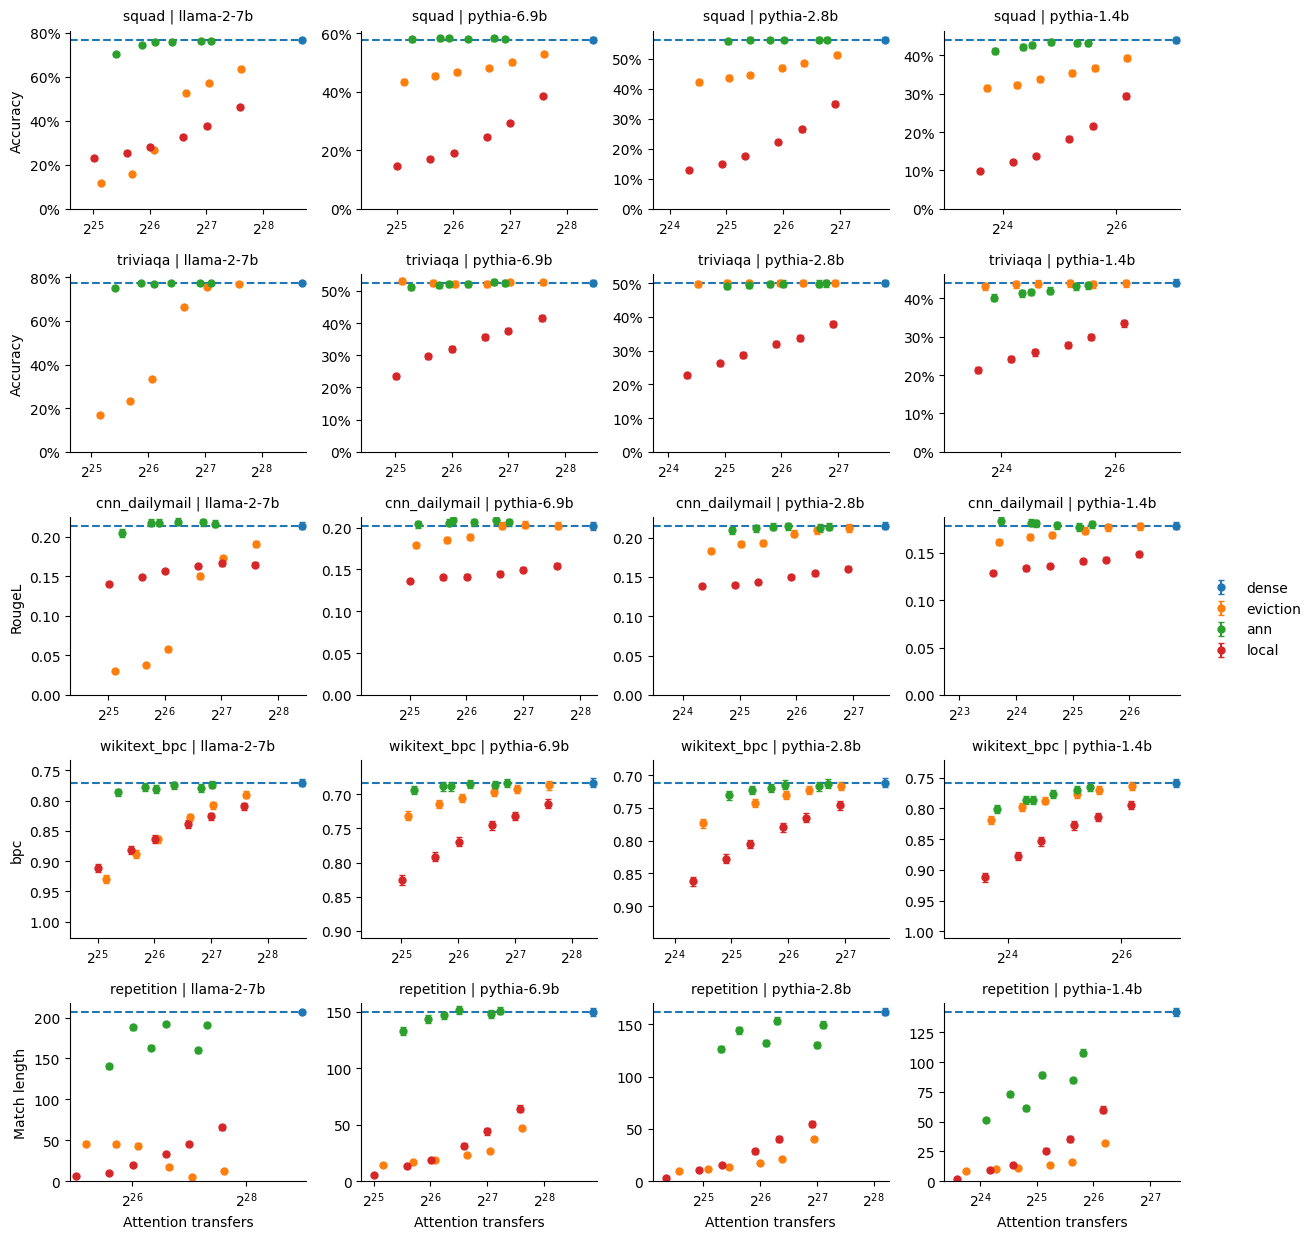

In [3]:
tasks = ["squad", "triviaqa", "cnn_dailymail", "wikitext_bpc", "repetition"]
models = ["llama-2-7b", "pythia-6.9b", "pythia-2.8b", "pythia-1.4b"]

fig, axs = plt.subplots(len(tasks), len(models), figsize=(3*len(models), 2.5*len(tasks)))

for task, axr in zip(tasks, axs):
    for model, ax in zip(models, axr):
        sns.despine(ax=ax)
        ax.set_title(f"{task} | {model}", fontsize=10, pad=8)
        if model == models[0]:
            ax.set_ylabel(dict(squad="Accuracy", triviaqa="Accuracy", cnn_dailymail="RougeL", wikitext_bpc="bpc", repetition="Match length")[task])
        if task in ["squad", "triviaqa"]:
            ax.yaxis.set_major_formatter("{x:.0%}")

        d = df[(df.task==task) & (df.model==model)]
        if len(d):
            for name in ["dense", "eviction", "ann", "local"]:
                g = d[d.name==name]
                ax.errorbar(x=g.transfers, y=g.score, yerr=g.score_stderr, fmt="o", ms=5, capsize=2, label=name)
            g = d[d.name=="dense"]
            transfers = g.transfers.item()
            score = g.score.item()
            ax.hlines(score, transfers/17, transfers*1.05, linestyles="--")
            ax.set_xscale("log", base=2)
            ax.set_xlim((transfers/17, transfers*1.05))
            ax.set_ylim((score/.75, score/1.05) if task == "wikitext_bpc" else (score*0, score*1.05))
        else:
            ax.remove()

for ax in axs[-1, :]:
    ax.set_xlabel("Attention transfers")
fig.legend(*axs[0, 0].get_legend_handles_labels(), loc="center left", bbox_to_anchor=(1.0, 0.5), frameon=False)
plt.tight_layout()